In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100)
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(image_count)
print(image_height)
print(image_width)
print(class_count)
print(faces.target_names)
print(faces.images.shape)


1140
62
47
5
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


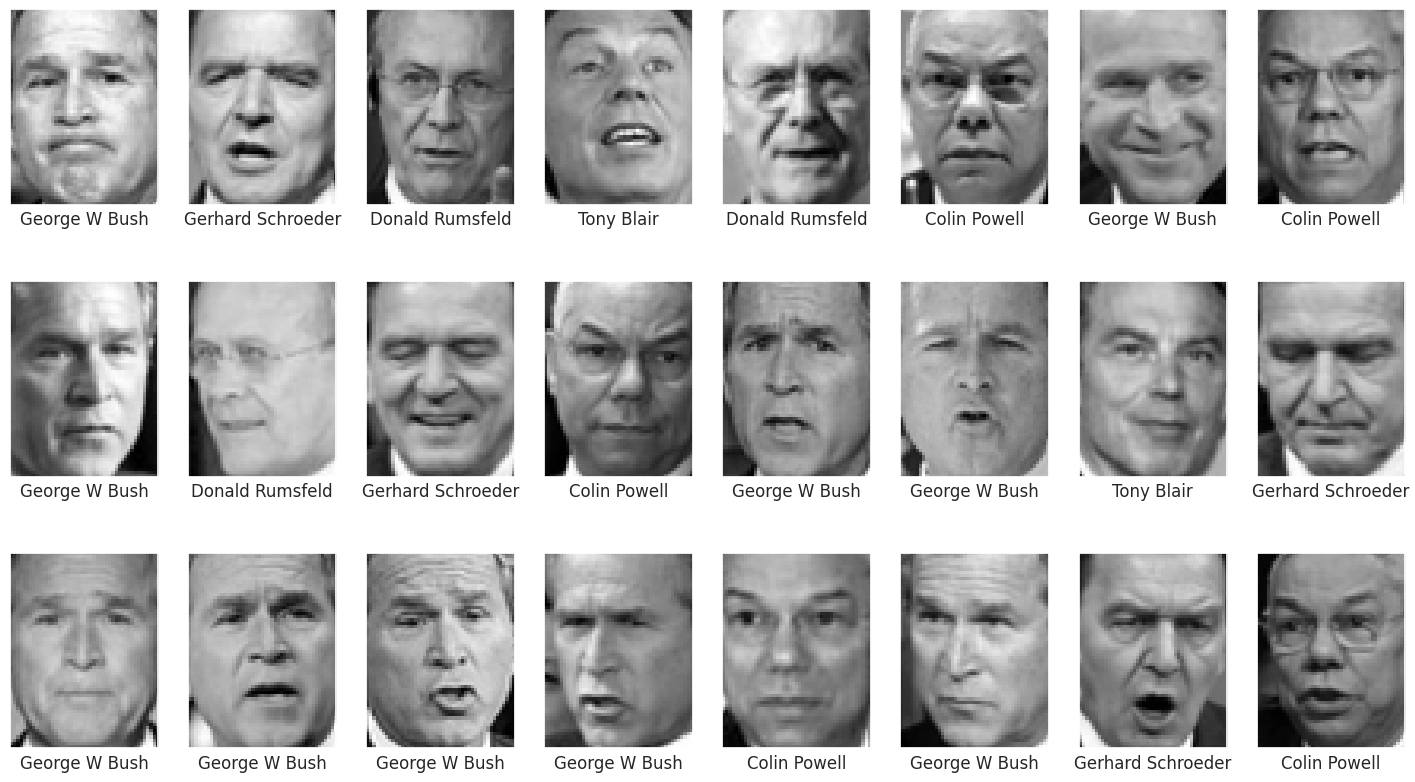

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

<Axes: >

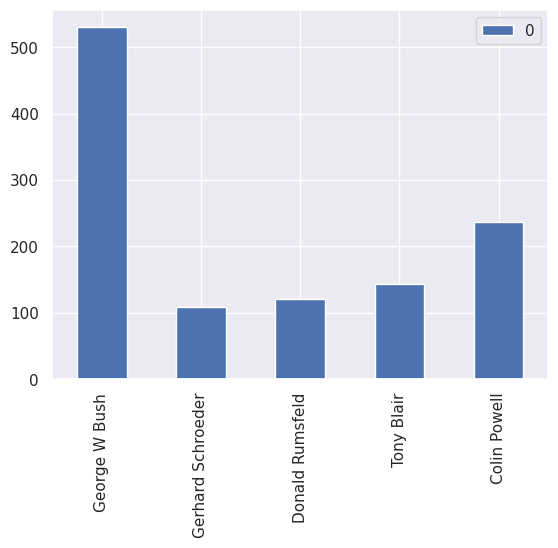

In [ ]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [ ]:
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces / 255
face_labels = to_categorical(y_faces)

# x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

In [ ]:

# First split: Split into training and temporary sets
x_train_temp, x_test, y_train_temp, y_test = train_test_split(
    face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0
)

# Second split: Split the temporary set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_temp, y_train_temp, train_size=0.80, stratify=y_train_temp, random_state=0
)

# Here, 80% of the original data is split into 75% training and 25% validation
# resulting in 64% training data, 16% validation data, and 20% test data


In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((320, 2914), (100, 2914), (320, 5), (100, 5))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import regularizers

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision_value = self.precision.result()
        recall_value = self.recall.result()
        return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define the model
# model1 = Sequential()
# model1.add(Dense(512, activation='relu', input_shape=(image_width * image_height,), kernel_regularizer=l2(0.001)))
# model1.add(BatchNormalization())
# model1.add(Dropout(0.5))
# model1.add(Dense(class_count, activation='softmax'))

model1 = Sequential()
model1.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model1.add(Dense(class_count, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])
model1.summary()

# # Compile the model
# model1.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()]
# )

# Display the model summary
# model1.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
hist = model1.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       1,492,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,495,045 (5.70 MB)

 Trainable params: 1,495,045 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.1843 - f1_score: 0.0000e+00 - loss: 1.6125 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2000 - val_f1_score: 0.0000e+00 - val_loss: 1.6098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2264 - f1_score: 0.0000e+00 - loss: 1.6070 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2000 - val_f1_score: 0.0000e+00 - val_loss: 1.6073 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2240 - f1_score: 0.0000e+00 - loss: 1.6065 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2000 - val_f1_score: 0.0000e+00 - val_loss: 1.6061 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2251 - f1_score: 0.0000e+00 - loss: 1.6050 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0

In [ ]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model1.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.7038 - f1_score: 0.4419 - loss: 1.0945 - precision: 0.8287 - recall: 0.3014
Test Loss: 1.0806
Test Accuracy: 0.7100
Test Precision: 0.8286
Test Recall: 0.2900
Test F1 Score: 0.4296


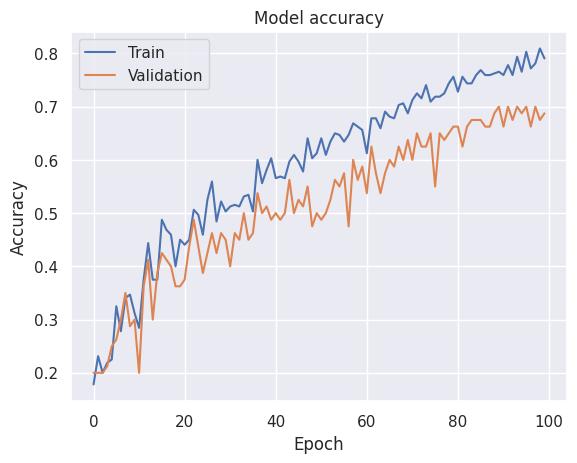

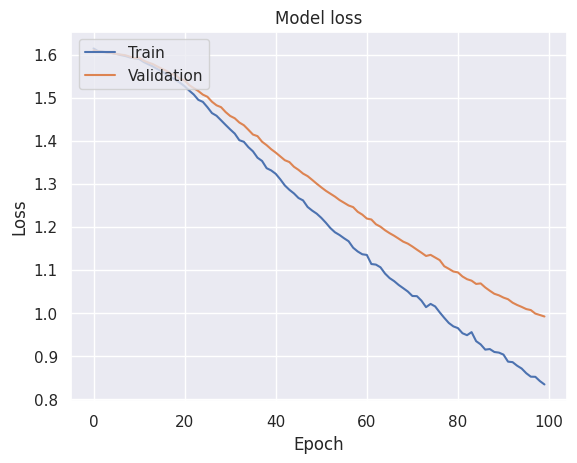

In [ ]:
import matplotlib.pyplot as plt


history = hist
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


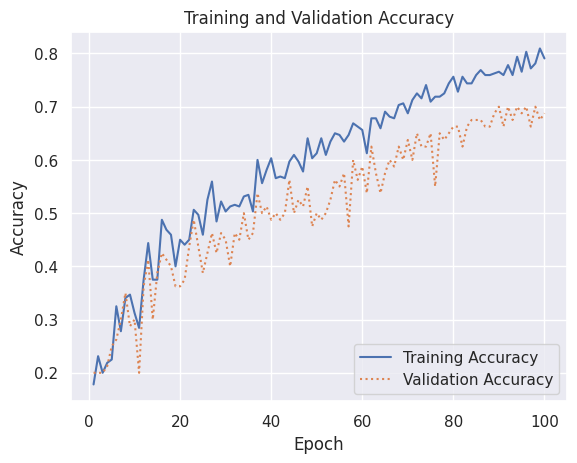

In [ ]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

show_history(hist)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Text(109.44999999999996, 0.5, 'Actual label')

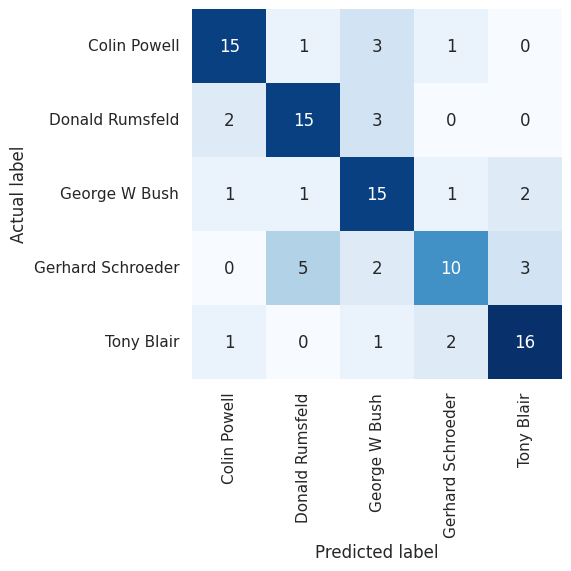

In [ ]:
from sklearn.metrics import confusion_matrix

y_predicted = model1.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7038 - f1_score: 0.4419 - loss: 1.0945 - precision: 0.8287 - recall: 0.3014 
Test Loss: 1.0806
Test Accuracy: 0.7100
Test Precision: 0.8286
Test Recall: 0.2900
Test F1 Score: 0.4296


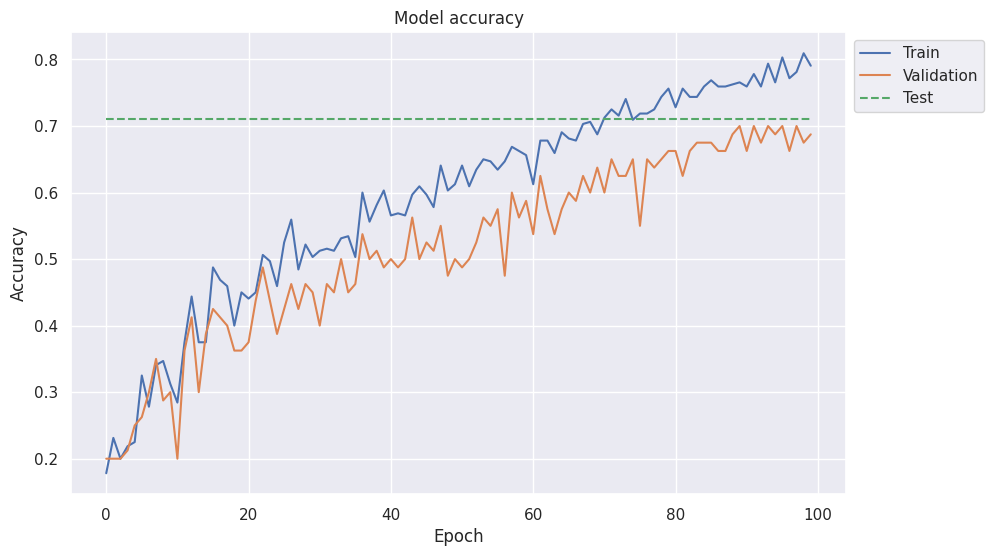

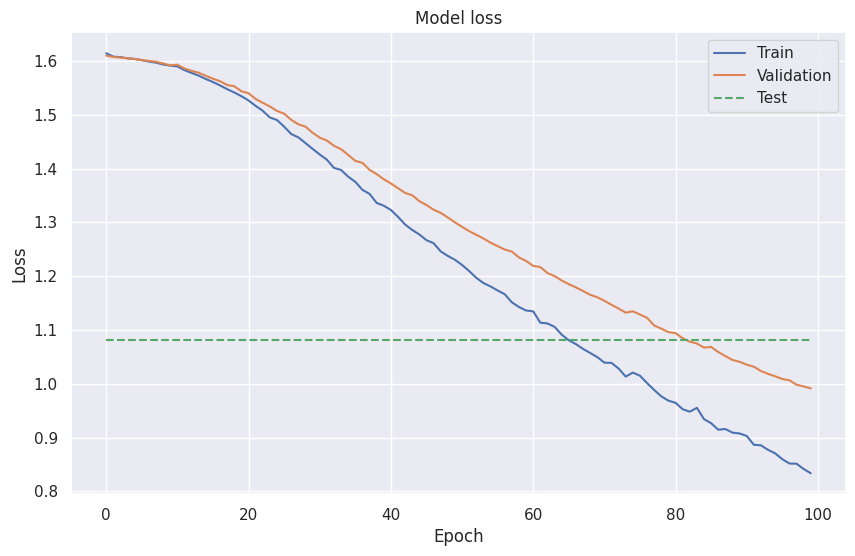

In [ ]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model1.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

import matplotlib.pyplot as plt

# Assuming `hist` is the history object returned from model.fit()
history = hist

# Adding the test accuracy and test loss to the history object for plotting
history.history['test_accuracy'] = [test_accuracy] * len(history.history['accuracy'])
history.history['test_loss'] = [test_loss] * len(history.history['loss'])

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['test_accuracy'], linestyle='--')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation', 'Test'], loc='best', bbox_to_anchor=(1, 1))
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['test_loss'], linestyle='--')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation', 'Test'], loc='best', bbox_to_anchor=(1, 1))
plt.show()
